In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn as nn

c:\Users\mlfav\anaconda3\envs\kjk_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dataset = load_dataset(path=r"C:\Users\mlfav\lib\shlee\color_model\ColorSuggestion", split="train")
dataset.set_format(type="torch", columns=["input_data", "output_color"], dtype=torch.float32)
dataset.shape

c:\Users\mlfav\anaconda3\envs\kjk_py39\lib\site-packages\datasets\load.py:922: FutureWarning: The repository for ColorSuggestion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at C:\Users\mlfav\lib\shlee\color_model\ColorSuggestion\ColorSuggestion.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


(57243, 16)

In [4]:
total_size = len(dataset)
train_size = int(total_size * 0.6)
valid_size = total_size - train_size
train_data, valid_data = random_split(dataset, [train_size, valid_size])
train_size, valid_size

(34345, 22898)

In [45]:
train_loader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=True, num_workers=2, drop_last=True)

In [46]:
data = train_loader.__iter__().__next__()
input_size = data['input_data'].shape[1]
input_size

119

In [47]:
output_size = data['output_color']
output_size

tensor([[137.1430,  22.8260,  36.0780]])

In [74]:
class LassoModel(nn.Module):
    def __init__(self, input_size, alpha):
        super(LassoModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.alpha = alpha

    def forward(self, x):
        x = self.linear(x)
        return x

In [75]:
class LassoLoss(nn.Module):
    def __init__(self, alpha):
        super(LassoLoss, self).__init__()
        self.alpha = alpha

    def forward(self, y_pred, y_true, model):
        mse_loss = nn.functional.mse_loss(y_pred, y_true)

        l1_regularization = self.alpha * torch.sum(torch.abs(model.linear.weight))
        
        total_loss = mse_loss + l1_regularization

        return total_loss

In [76]:
epochs = 100
learning_rate = 0.0002

In [77]:
alpha = 0.01
model = LassoModel(input_size, alpha).to(device)

criterion = LassoLoss(alpha)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [78]:
learning_rates = []

In [79]:
def train_epoch(train_loader):
    train_loss = []
    for data in train_loader:
        x = data['input_data'].to(device)
        y = data['output_color'].to(device)

        output = model.forward(x)
        loss = criterion(output, y, model)

        l1_regularization = torch.sum(torch.abs(model.linear.weight))
        loss += alpha * l1_regularization

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().detach().numpy())

    return np.array(train_loss).mean()

def valid_epoch(valid_loader):
    valid_loss = []
    for data in valid_loader:
        x = data['input_data'].to(device)
        y = data['output_color'].to(device)

        output = model.forward(x)
        loss = criterion(output, y, model)
        valid_loss.append(loss.cpu().detach().numpy())
    return np.array(valid_loss).mean()

In [80]:
train_loss = []
valid_loss = []

for epoch in range(epochs):
    
    t_loss = train_epoch(train_loader)
    v_loss = valid_epoch(valid_loader)
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    print(f"train: {t_loss}, valid: {v_loss}")

C:\Users\mlfav\AppData\Local\Temp\ipykernel_12864\2528880567.py:7: UserWarning: Using a target size (torch.Size([1, 3])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = nn.functional.mse_loss(y_pred, y_true)


In [ ]:
plt.figure(figsize=(10,5))
plt.plot([float(loss) for loss in train_loss], label='Train Loss')
plt.plot([float(loss) for loss in valid_loss], label='Valid Loss')
# plt.plot([float(lr[0]) for lr in learning_rates], label='Learning Rate')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [121]:
with torch.no_grad():
    x = data['input_data'].to(device)
    y = data['output_color']
    output = model.forward(x)

In [122]:
print(y)
print(output)

tensor([[20.0000, 63.5760, 59.2160],
        [17.5000, 23.8810, 78.8240],
        [30.0000, 29.2680, 64.3140],
        [28.6960, 32.8570, 54.9020]])
tensor([136.9935,  44.5627,  64.0430], device='cuda:0')


In [119]:
rgb = RGB[0].type(torch.int).cpu().detach().numpy().reshape((4,1,3))
label = y[0].type(torch.int).numpy().reshape((1,3))
val = output.type(torch.int).cpu().detach().numpy()
rgb

array([[[ 56,  53,  48]],

       [[ 30,  89, 120]],

       [[137,  95,  52]],

       [[185,  76,   4]]])

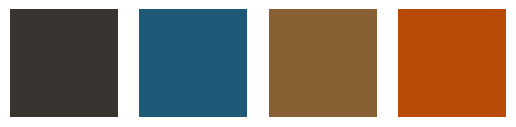

In [120]:
for i in range(4):
    a = rgb[i].reshape((1,3))
    plt.subplot(1,4,i+1)
    plt.imshow([a])
    plt.axis(False)